In [1]:
import os
os.chdir('..')
import config
import h5py
import numpy as np
import cartopy.crs as ccrs
import numpy as np
import glob
from utils.imgShow import imgShow
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.transform_xy import coor2coor
from utils.make_grid import make_grid
from utils.mad_std import mad_std
from utils.spatial_filter import spatial_filter
from utils.interp2d import interp2d
from utils.tiffread import tiffread
from utils.binning import binning_1d
from scipy.ndimage.filters import generic_filter
from utils.interpkrig import interpkrig
from utils.interpmed import interpmed
from utils.interpgaus import interpgaus


In [2]:
# !python ../utils/readatl06.py -h
# !python utils/merge.py -h


In [3]:
# !h5ls data/icesat2/land_ice_antarctic/processed_ATL06_20181016093821_02710110_004_01.h5



In [4]:
# #### Data preparation
# !python utils/readatl06.py data/icesat2/land_ice_antarctic/*ATL06*.h5 -o data/icesat2/land_ice_antarctic/preprocessed -n 4
# !python utils/merge.py data/icesat2/land_ice_antarctic/preprocessed/*ATL06*_A*.h5 -o data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_A_merge.h5
# !python utils/merge.py data/icesat2/land_ice_antarctic/preprocessed/*ATL06*_D*.h5 -o data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D_merge.h5



In [2]:
path_img = config.root + '/data/rs_img/pine_island_S3A_20180207T115228_20180207T115528.tif'
path_atl06_A_merge = config.root + '/data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_A_merge.h5'
path_atl06_D_merge = config.root + '/data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D_merge.h5'



In [3]:
s3_img, s3_img_info = readTiff(path_img)
print(s3_img_info)



{'geoextent': (-1741002.5304, -1437153.6139, -380178.3167, -165679.325), 'geotrans': (-1741002.5304, 295.8606781888998, 0.0, -165679.325, 0.0, -295.8606782068966), 'geosrs': '3031', 'row': 725, 'col': 1027, 'bands': 3}


In [4]:
with h5py.File(path_atl06_D_merge,'r') as f_a:
    lat_mergeD   = f_a['lat'][:]
    lon_mergeD   = f_a['lon'][:]
    h_elv = f_a['h_elv'][:]
    t_yrs_mergeD = f_a['t_year'][:]

lon_mergeD_proj, lat_mergeD_proj = coor2coor(srs_from=4326, srs_to=s3_img_info['geosrs'], x=lon_mergeD, y=lat_mergeD)


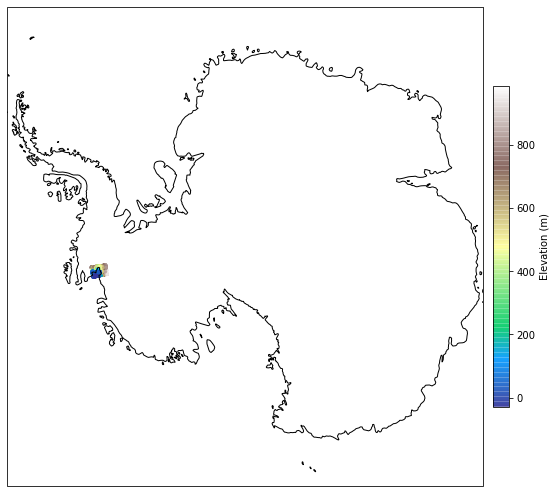

In [5]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -66], crs=ccrs.PlateCarree())
plt.scatter(lon_mergeD[::100], lat_mergeD[::100], s=3, c=h_elv[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='terrain')
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')



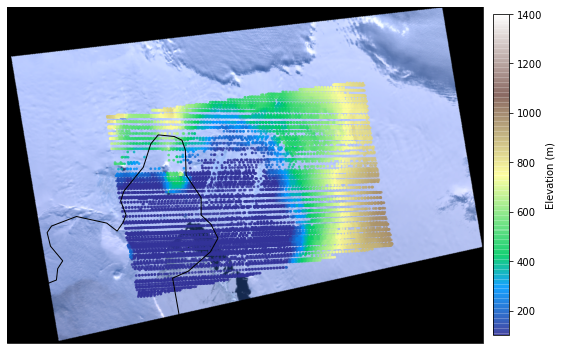

In [6]:
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_mergeD_proj[::100], lat_mergeD_proj[::100], s=3, c=h_elv[::100], alpha=.7, cmap='terrain')
plt.clim([100,1400])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')


In [7]:
print(f'Min. height:{int(h_elv.min())} m, Max. height: {int(h_elv.max())} m')


Min. height:-30 m, Max. height: 992 m


Text(0.5, 0, 'Elevation (m)')

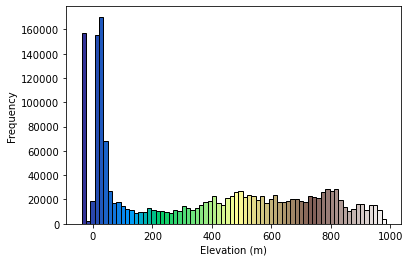

In [8]:
cm = plt.cm.get_cmap('terrain')
Y, X = np.histogram(h_elv, 70)
x_span = h_elv.max()-h_elv.min()
C = [cm(((x-X.min())/x_span)) for x in X]
plt.bar(X[:-1], Y, color=C, width=X[1]-X[0], edgecolor='k')
plt.ylabel('Frequency')
plt.xlabel('Elevation (m)')


In [12]:
# !python utils/fittopo.py -h


In [10]:
# !python utils/fittopo.py data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_A_merge.h5 -d 1 1 -r 1.0 -q 3 -i 5 -z 10 -m 100 -k 2 -j 3031 -v lon lat t_year h_elv -s 10 -p
!python utils/fittopo_.py data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D_merge.h5 -d 1 1 -r 1.0 -q 3 -i 5 -z 10 -m 100 -k 2 -j 3031 -v lon lat t_year h_elv -s 10 -p


parameters:
('files', ['data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D_merge.h5'])
('dxy', [1.0, 1.0])
('radius', [1.0])
('nreloc', [3])
('niter', [5])
('minobs', [10])
('mlim', [100])
('order', [2])
('tref', ['fixed'])
('proj', ['3031'])
('vnames', ['lon', 'lat', 't_year', 'h_elv'])
('expr', [None])
('njobs', [1])
('slplim', [10.0])
('pshow', True)
running sequential code ...
loading data ...
converting lon/lat to projected x/y ...
building the k-d tree ...
predicting values ...
# 3000 / 25071 Model: 2 Nobs: 128 Slope: 1.463 Residual: 1.097
# 5000 / 25071 Model: 1 Nobs: 756 Slope: 0.026 Residual: 0.245
# 6000 / 25071 Model: 1 Nobs: 982 Slope: 1.203 Residual: 1.263
# 7000 / 25071 Model: 1 Nobs: 473 Slope: 0.459 Residual: 0.669
# 8000 / 25071 Model: 1 Nobs: 215 Slope: 10.076 Residual: 1.561
# 9000 / 25071 Model: 1 Nobs: 425 Slope: 1.166 Residual: 3.053
# 10000 / 25071 Model: 2 Nobs: 183 Slope: 1.202 Residual: 5.895
# 11000 / 25071 Model: 2 Nobs: 199 Slope: 3.188 Residua

In [14]:
# !ls data/icesat2/land_ice_antarctic/preprocessed/pineisland*
# !h5ls data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D_merge_TOPO.h5


In [15]:
# !python utils/merge.py data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_*_TOPO.h5 -o data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_TOPO_AD.h5


In [16]:
with h5py.File('data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_TOPO_AD.h5','r') as f_r:
    lat_TOPO = f_r['lat'][:]
    lon_TOPO = f_r['lon'][:]
    t_TOPO = f_r['t_year'][:]
    h_TOPO_res = f_r['h_res'][:]
    h_TOPO_mod = f_r['h_mod'][:]
    h_TOPO_org = f_r['h_elv'][:]

lon_TOPO_proj, lat_TOPO_proj = coor2coor('4326', '3031', lon_TOPO, lat_TOPO)



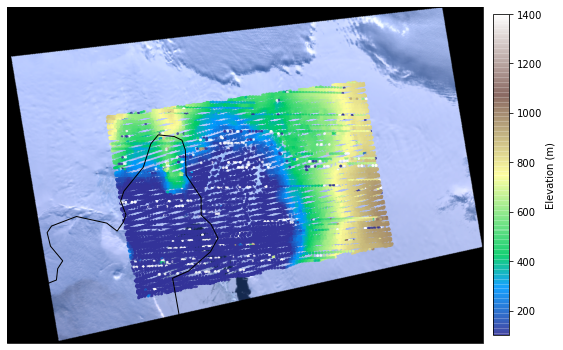

In [17]:
## ------ before/after spatial-temporal smooth
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
# plt.scatter(lon_mergeD_proj[::100], lat_mergeD_proj[::100], s=3, c=h_elv[::100], alpha=.7, cmap='terrain')
plt.scatter(lon_TOPO_proj[::100], lat_TOPO_proj[::100], s=3, c=h_TOPO_org[::100]-h_TOPO_res[::100], alpha=.7, cmap='terrain')
plt.clim([100,1400])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')


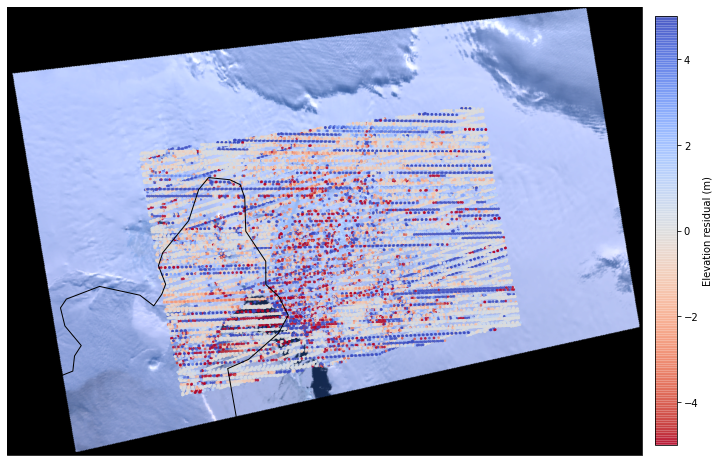

In [18]:
## ------ height residual after spatial-temporal smooth
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_TOPO_proj[::100], lat_TOPO_proj[::100], s=3, \
                                c=h_TOPO_res[::100], alpha=.7, cmap='coolwarm_r')
plt.clim([-5,5])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation residual (m)')
ax.coastlines('50m')


Mean: 7.316 cm
Std.dev: 185.909 cm
Rejected: 7.85 %


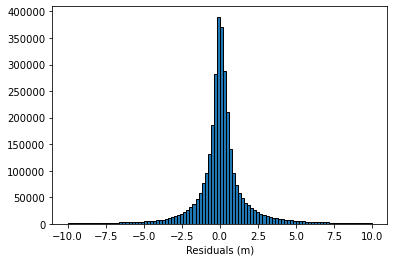

In [19]:
h_TOPO_res[np.abs(h_TOPO_res) > 10] = np.nan 
fig = plt.hist(h_TOPO_res[~np.isnan(h_TOPO_res)], 100, edgecolor='k')
plt.xlabel('Residuals (m)')
print('Mean:', np.around(100*np.nanmean(h_TOPO_res),3), 'cm')
print('Std.dev:',np.around(100*np.nanstd(h_TOPO_res),3), 'cm')
print('Rejected:', np.around(100*(float(len(h_TOPO_res[np.isnan(h_TOPO_res)]))/len(h_TOPO_res)),2), '%')


## Spatio-temporal interpolation
Ok we now have tons of data here! Remember ICESat-2 ATL06 product has an along-track sampling of 20 m, so we need to reduce this data into workable format for further analysis. One way of doing this is to interpolate the data to a regular grid with a specific resolution. In our tutorial we are going to do this in both space and time to create monthly time series in the form of a data cube. A simple program for this purpose is interpgaus3d.py available in captoolkit (there is many more that work both in 2d and 3d). This is a simple 3D (or you might want to call it 4D) interpolator using a gaussian kernel in both space and time to compute a value at each grid node.

Later in the tutorial we are going to discuss different interpolation techniques in more detail

Let have a look at the program and its input!

In [20]:
# !h5ls data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_TOPO_AD.h5


In [21]:
# !python utils/interpgaus3d.py -h


In [22]:
# !python utils/interpgaus3d.py data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_TOPO_AD.h5 data/icesat2/land_ice_antarctic/preprocessed/pineisland_data_cube.h5 -d 2 2 -t 2018.9 2020.4 0.25 \
# -r 30 -a 10 0.25 -p 3031 -c 100 3 10 -v lon lat h_res t_year dummy -s 100



In [23]:
# !h5ls data/icesat2/land_ice_antarctic/preprocessed/pineisland_data_cube.h5



## Before Spatio-temporal interpolation (mergeAD, linear fitting by fittopo.py)

In [24]:
z_TOPO = spatial_filter(lon_TOPO_proj, lat_TOPO_proj, h_TOPO_res.copy(), dx=100e3, dy=100e3, sigma=3)


In [25]:
print('Mean:', np.around(100*np.nanmean(z_TOPO),3), 'cm/yr')
print('Std.dev:', np.around(100*np.nanstd(z_TOPO),3), 'cm/yr')
print('Rejected:', np.around(100*(float(len(z_TOPO[np.isnan(z_TOPO)]))/len(z_TOPO)),2), '%')   # nan values/all values


Mean: 4.277 cm/yr
Std.dev: 142.151 cm/yr
Rejected: 10.35 %


Text(0.5, 0, 'Residuals (m)')

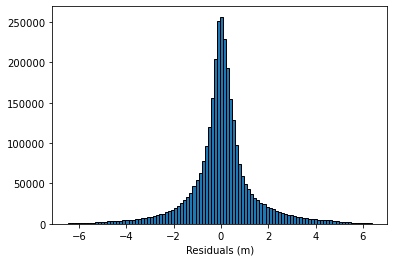

In [26]:
fig = plt.hist(z_TOPO[~np.isnan(z_TOPO)], 100, edgecolor='k')
plt.xlabel('Residuals (m)')



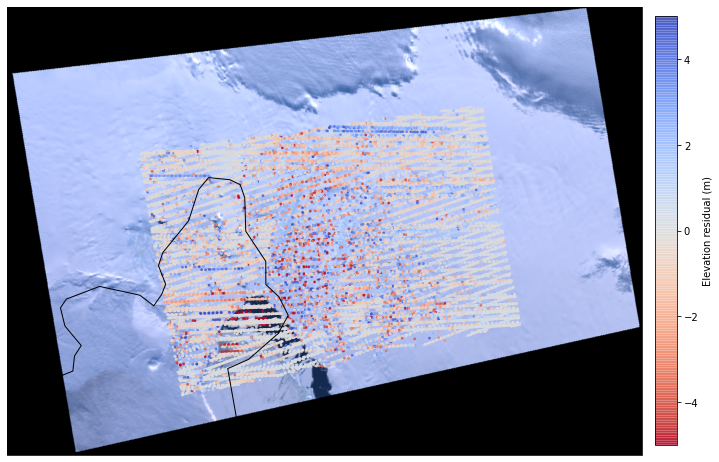

In [27]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_TOPO_proj[::100], lat_TOPO_proj[::100], s=3, c=z_TOPO[::100], \
                                    alpha=.7, cmap='coolwarm_r')
plt.clim([-5,5])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation residual (m)')
ax.coastlines('50m')


Text(0.5, 0, 'Time (yrs)')

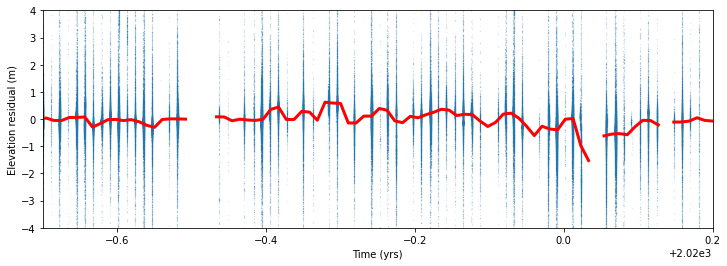

In [28]:
plt.figure(figsize=(12,4))
xb, yb = binning(t_TOPO, z_TOPO, xmin=2019.2, xmax=2020.3, dx=0.125 / 12., window=0.25 / 12., median=True)[0:2]
plt.plot(t_TOPO[::10], z_TOPO[::10],'.',markersize=0.1)
plt.plot(xb, yb, '-r', linewidth=3)
plt.ylim([-4, 4])
plt.xlim([2019.3, 2020.2])
plt.ylabel('Elevation residual (m)')
plt.xlabel('Time (yrs)')


In [29]:
p = np.polyfit(t_TOPO[~np.isnan(z_TOPO)], z_TOPO[~np.isnan(z_TOPO)], deg=1)   
print('Trend:',np.around(p[0],2),'(m/yr)')



Trend: -0.49 (m/yr)


## After Spatio-temporal interpolation (data_cube, interpolation by interpgaus3d.py)

In [30]:
## obtain the groud truth value of the icesat2 points through interpolation from the groud truth points
# Zmi = interp2d(Xm, Ym, Zm, Xi.ravel(), Yi.ravel(), order=0).reshape(Xi.shape)


In [31]:
with h5py.File('data/icesat2/land_ice_antarctic/preprocessed/pineisland_data_cube.h5','r') as f_c:
    print(f_c.keys())
    lon_cube_proj = f_c['X'][:]
    lat_cube_proj = f_c['Y'][:]
    ti_cube = f_c['time'][:]
    zi_cube = f_c['Z_pred'][:]

lon_cube, lat_cube = coor2coor('3031', '4326', lon_cube_proj, lat_cube_proj)


<KeysViewHDF5 ['X', 'Y', 'Z_nobs', 'Z_pred', 'Z_rmse', 'epsg', 'time']>


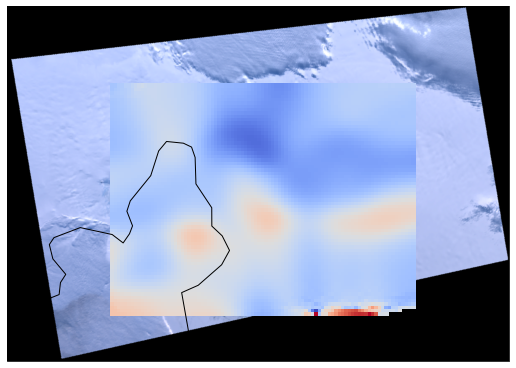

In [32]:
time_ind = 10
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.pcolormesh(lon_cube_proj, lat_cube_proj, zi_cube[time_ind,::], cmap='coolwarm_r')
ax.coastlines('50m')


In [33]:
zi_cube_mean = np.nanmean(np.nanmean(zi_cube,1),1)  # along the temporal dimension


Interpolated data fitting: -0.28
Smoothed data fitting: -0.49


Text(0, 0.5, 'Elevation residuals (m)')

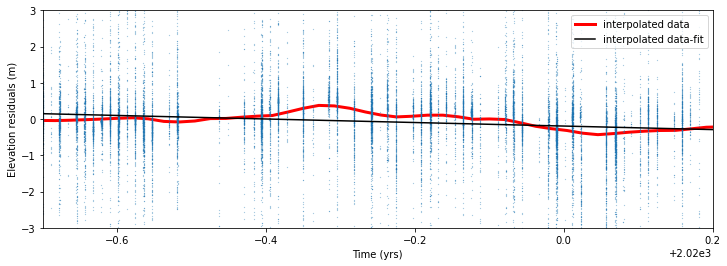

In [34]:
plt.figure(figsize=(12,4))
plt.plot(ti_cube, zi_cube_mean,'r',linewidth=3, label='interpolated data')
plt.plot(t_TOPO[::100], h_TOPO_res[::100], '.', markersize=0.3,linewidth=3) # spatial-temporal smooth

p1 = np.polyfit(ti_cube[~np.isnan(zi_cube_mean)], zi_cube_mean[~np.isnan(zi_cube_mean)], 1) # spatial-temporal interploation
p2 = np.polyfit(t_TOPO[~np.isnan(z_TOPO)], z_TOPO[~np.isnan(z_TOPO)],1)  # spatial-temporal smooth
plt.plot(ti_cube, np.polyval(p2, ti_cube),'k',label='interpolated data-fit')
plt.legend()
print('Interpolated data fitting:',np.around(p1[0],2))
print('Smoothed data fitting:',np.around(p2[0],2))
plt.xlim([2019.3, 2020.2])
plt.ylim([-3,3])
plt.xlabel('Time (yrs)')
plt.ylabel('Elevation residuals (m)')


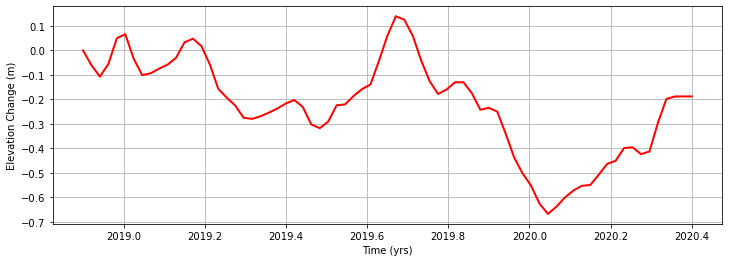

In [35]:
plt.figure(figsize=(12,4))
plt.plot(ti_cube, zi_cube_mean - zi_cube_mean[0],'r',linewidth=2)
plt.ylabel('Elevation Change (m)')
plt.xlabel('Time (yrs)')
plt.grid()


In [36]:
nt,nx,ny = zi_cube.shape
zi_cube_fit_slope = np.zeros((nx,ny))*np.nan
for i in range(nx):
    for j in range(ny):
        dh = zi_cube[:,i,j]
        if np.any(np.isnan(dh)):continue
        zi_cube_fit_slope[i,j] = np.polyfit(ti_cube, zi_cube[:,i,j], 1)[0]


In [37]:
zi_cube_slope_smooth = generic_filter(zi_cube_fit_slope.copy(), np.nanmean, 3)
# zi_cube_slope_smooth[Zmi == 0] = np.nan



/Users/luo/miniconda3/envs/venv/lib/python3.6/site-packages/scipy/ndimage/filters.py:1528: RuntimeWarning: Mean of empty slice
  cval, origins, extra_arguments, extra_keywords)


Trend: -0.28 (m/yr)


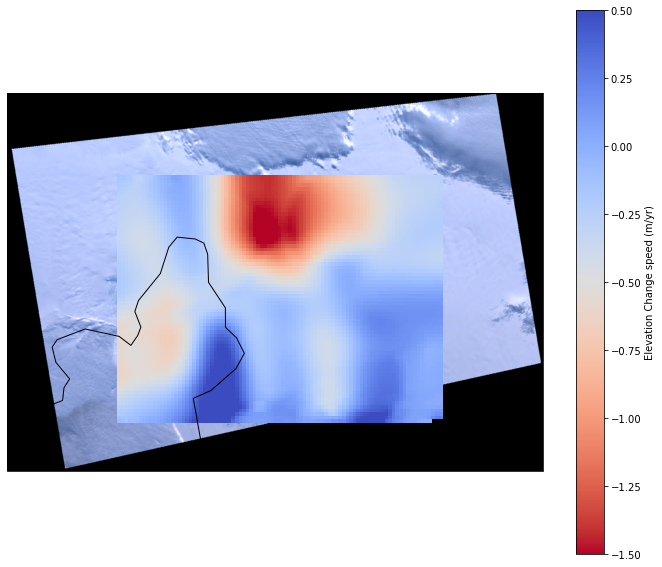

In [38]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
im = plt.pcolormesh(lon_cube_proj, lat_cube_proj, zi_cube_slope_smooth, cmap='coolwarm_r',vmin=-1.5, vmax=0.5)
ax.coastlines('50m')
plt.colorbar(label='Elevation Change speed (m/yr)')
print('Trend:',np.around(np.nanmean(zi_cube_slope_smooth),2),'(m/yr)')


In [39]:
dVdt = np.nansum(zi_cube_slope_smooth)*2e3*2e3*1e-9   # 2e3 corresponding to the dx and dy (spatial size of one grid).
print('Volume Change:', np.around(dVdt,1),'(km3/yr)')



Volume Change: -7.0 (km3/yr)


## Constructing a digital elevation model
From fittopo.py we also have the mean surface height from all our solutions and which are now referenced to the same common time 2020. So, let’s go through a few steps to show how we can obtain a DEM in a relatively easy manner.

In [40]:
h_TOPO_mod_copy = h_TOPO_mod.copy()


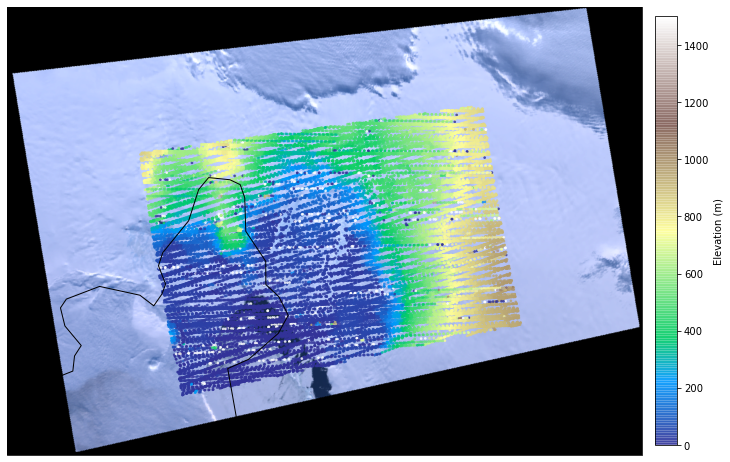

In [41]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_TOPO_proj[::100], lat_TOPO_proj[::100], s=3, c=h_TOPO_mod_copy[::100], \
                                alpha=.7, cmap='terrain')
plt.clim([0,1500])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')


In [42]:
h_TOPO_mod_copy[np.isnan(z_TOPO)] = np.nan


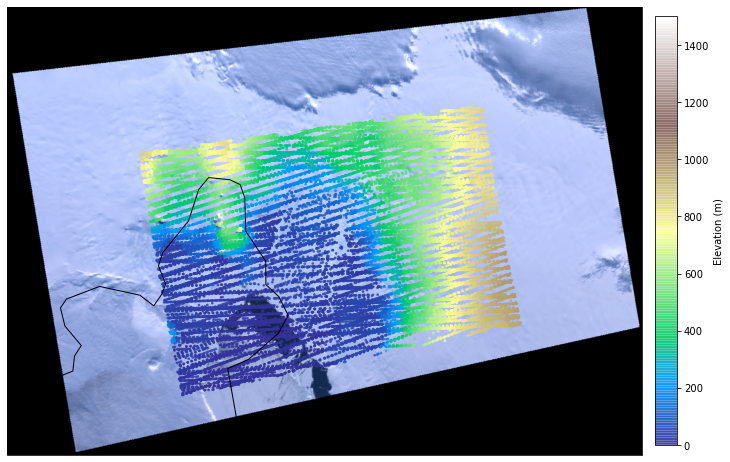

In [43]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_TOPO_proj[::100], lat_TOPO_proj[::100], s=3, c=h_TOPO_mod_copy[::100], \
                            alpha=.7, cmap='terrain')
plt.clim([0,1500])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')



In [44]:
# Zm_i = interp2d(Xm, Ym, Zm, Xdem.ravel(), Ydem.ravel(), order=1).reshape(Xdem.shape)    


In [45]:
# from utils import interpkrig, interpmed, interpgaus
# i_nan = ~np.isnan(h_h)


## Some common interpolation algorithm

**Kriging/Collocation (interpkrig):**   
Least-Squares Collocation (LSC), mostly known as Kriging, is a geostatistical method of spatial interpolation modeled by a gaussian process governed by the data covariance. In general the LSC method is better at preserving spatial detail and variability than other simpler distance-based interpolation methods, if the spatial auto-correlation of the data is substantial. LSC, also generates estimates of uncertainty for each prediction and also allows for error-propagation via the covariance structure.  
**Gaussian Weighed Average (interpgaus):**   
One of the most common interpolation approaches to interpolate irregular scattered data onto a regular grid using a weighted average, with a gaussian weighing function based on distance away from the prediction point. This interpolation approach provides a smooth continuous surface constrained by the range of the data. However, the weighted average is sensitive to large outliers and the data distribution, the same as for the median.   
**Median (interpmed):**  
 Using the median for spatial interpolation has some advantages, as it is less sensitive to outliers in the data, and thus provide very clean and nice-looking grids. However, for producing volume change estimates for large regions (continental) it is less useful. This is because, as we could see in the histogram, we usually have a negative skewed distributions of elevation change. Thus, using the median we will estimates value will be biased in the positive direction. Further, the usage of the median does not allow us to incorporate far-field data, as no weighting for distance is possible.

In [46]:
## _TOPO 
Xdem_TOPO, Ydem_TOPO = make_grid(lon_TOPO_proj.min(), lon_TOPO_proj.max(), \
                                            lat_TOPO_proj.min(), lat_TOPO_proj.max(), 1e3, 1e3)


In [47]:
### --------- interpolation on the smoothed data (_TOPO).
### --------- we also can interplate on the original data directively.
not_nan = ~np.isnan(h_TOPO_mod_copy)
z_dem_TOPO_interp = interpgaus(lon_TOPO_proj[not_nan][::100], lat_TOPO_proj[not_nan][::100], h_TOPO_mod_copy[not_nan][::100].copy(),\
                        np.ones(h_TOPO_mod_copy[not_nan][::100].shape)*1, Xdem_TOPO, Ydem_TOPO, n=20, d_max=20e3, a=5e3)[0]
# z_dem_TOPO_interp = interpmed(lon_TOPO_proj[not_nan][::100], lat_TOPO_proj[not_nan][::100], h_TOPO_mod_copy[not_nan][::100].copy(), \
#                             Xdem_TOPO, Ydem_TOPO, n=20, d_max=20e3)
# z_dem_TOPO_interp = interpkrig(lon_TOPO_proj[not_nan][::100], lat_TOPO_proj[not_nan][::100], h_TOPO_mod_copy[not_nan][::100].copy(), \
#                             np.ones(h_TOPO_mod_copy[not_nan][::100].shape)*1, Xdem_TOPO, Ydem_TOPO, n=20, d_max=20e3, a=5e3)[0]



In [48]:
Z_dem_TOPO_interp = z_dem_TOPO_interp.reshape(Xdem_TOPO.shape)



In [49]:
# Z_dem_mergeAD[Zm_i == 0] = np.nan


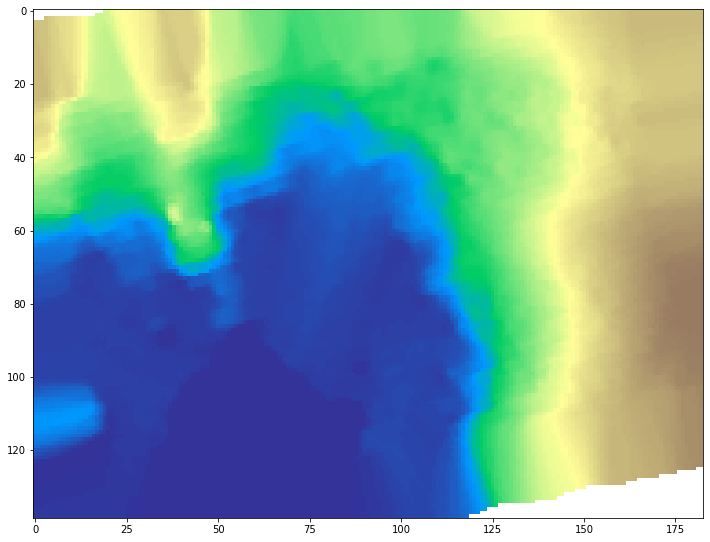

In [50]:
fig = plt.figure(figsize=(12,10))
plt.imshow(np.flipud(Z_dem_TOPO_interp), cmap='terrain', vmin=0, vmax=1400)



In [ ]:
# !python utils/xover.py -h


In [58]:
# !python utils/xover.py data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_A_merge.h5 data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D_merge.h5 -o data/icesat2/land_ice_antarctic/preprocessed/pineisland_xovers.h5 -r 100 -p 3031 -d 10 -k 20 20 -m linear -v orbit lon lat t_year h_elv dum dum dum


In [ ]:
# !h5ls data/icesat2/land_ice_antarctic/preprocessed/pineisland_xovers.h5


In [73]:
with h5py.File('data/icesat2/land_ice_antarctic/preprocessed/pineisland_xovers.h5','r') as f_xo:
    lon_xovers = f_xo['lon'][:]
    lat_xovers = f_xo['lat'][:]
    dh_xovers = f_xo['dh_elv'][:]
    dt_xovers = f_xo['dt_year'][:]
    dhdt_xovers = f_xo['dhdt'][:]
    print(f_xo.keys())

lon_xovers_proj, lat_xovers_proj = coor2coor('4326', '3031', lon_xovers, lat_xovers)
    

<KeysViewHDF5 ['dh_elv', 'dhdt', 'dt_year', 'h_elv_1', 'h_elv_2', 'lat', 'lon', 'orbit_1', 'orbit_2', 't_year_1', 't_year_2']>


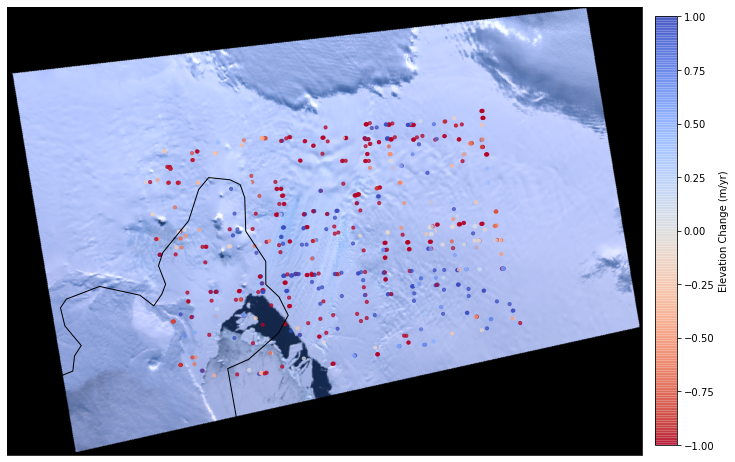

In [77]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ids = np.abs(dt_xovers)>3./12
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_xovers_proj[ids], lat_xovers_proj[ids], s=10, c=dh_xovers[ids]/dt_xovers[ids], \
                            alpha=.7, cmap='coolwarm_r')
plt.clim([-1.,1.])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation Change (m/yr)')
ax.coastlines('50m')


In [ ]:
# x_xovers, y_xovers = coor2coor('4326','3031',lon_xovers, lat_xovers)


Text(0.5, 0, 'dt_xovers')

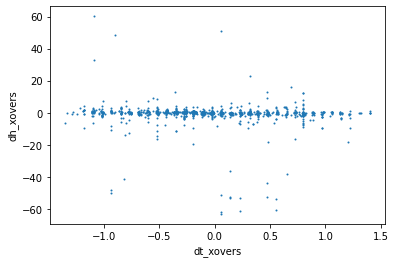

In [85]:
plt.plot(dt_xovers, dh_xovers, '.', markersize=2)
plt.ylabel('dh_xovers')
plt.xlabel('dt_xovers')


Trend: -0.45 (m/yr)


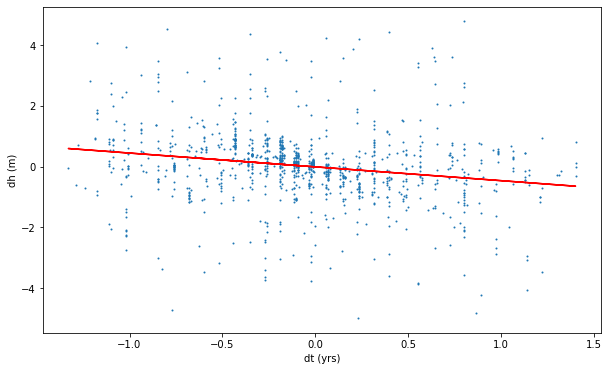

In [84]:
plt.figure(figsize=(10,6))
idx = np.abs(dh_xovers)<5
plt.plot(dt_xovers[idx], dh_xovers[idx],'.', markersize=2)
c_fit = np.polyfit(dt_xovers[idx], dh_xovers[idx], 1)
plt.plot(dt_xovers[idx], np.polyval(c_fit, dt_xovers[idx]), 'r')
plt.ylabel('dh (m)')
plt.xlabel('dt (yrs)')
print('Trend:', np.around(c_fit[0], 2),'(m/yr)')


dh_1month: -0.42 cm
Error: 24.99 cm


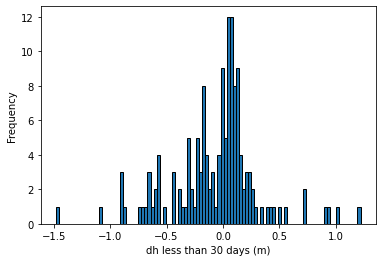

In [89]:
idx = (np.abs(dh_xovers) < 2) & (np.abs(dt_xovers) < 1./12)
x_thre, y_thre, dt_thre, dh_thre = lon_xovers_proj[idx], lat_xovers_proj[idx], dt_xovers[idx], dh_xovers[idx]
fig = plt.hist(dh_thre[np.abs(dh_thre) < 1.5], 100, edgecolor='k')
plt.xlabel('dh less than 30 days (m)')
plt.ylabel('Frequency')
print('dh_1month:',np.around(np.nanmedian(dh_thre)*100, 2), 'cm')
print('Error:',np.around(mad_std(dh_thre)*100, 2), 'cm')
